# Discrete Fourier Transform

$$ D_k(z) = \sum_{j=0}^{n-1}z_j e^{-\frac{2i \pi j k}{n}} $$

$$ D_k^{-1}(z) = \frac{1}{n}\sum_{j=0}^{n-1}z_j e^{\frac{2i \pi j k}{n}} $$

https://www.davidhbailey.com/dhbpapers/fracfft.pdf

https://www.davidhbailey.com/dhbpapers/fourint.pdf

In [1]:
import numpy as np

def dft(Z):
    n = len(Z)
    L = np.zeros_like(Z, dtype=complex)
    for k in range(n):
        for j in range(n):
            L[k] += Z[j]*np.exp(-2*1j*np.pi*j*k/n)
    return L

def idft(Z):
    n = len(Z)
    L = np.zeros_like(Z, dtype=complex)
    for k in range(n):
        for j in range(n):
            L[k] += (1/n) * Z[j] * np.exp(2*1j*np.pi*j*k/n)
    return L

Error :  6.069270725473981e-14


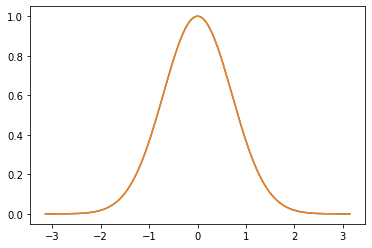

In [2]:
import matplotlib.pyplot as plt

def error(y, x):
    e = max(abs(x - y))/max(abs(x))
    print("Error : ", e)

x = np.linspace(-np.pi, np.pi, 256)
y = np.exp(-x*x)
z_dft = dft(y)
y_dft = idft(z_dft)
plt.plot(x, y)
plt.plot(x, y_dft.real)

error(y_dft, y)

# Fast Fourier Transform

In [3]:
def fft(Z):
    n = len(Z)
    if n <= 1:
        return Z.copy()
    else:
        assert(n % 2 == 0)
        even = fft(Z[::2])
        odd = fft(Z[1::2])
        result = np.zeros_like(Z, dtype=complex)
        factors = np.exp(-2*1j*np.pi*np.arange(n//2)/n)
        result[:n//2] = even + factors * odd
        result[n//2:] = even - factors * odd
        return result
    
def ifft(Z):
    n = len(Z)
    if n <= 1:
        return Z.copy()
    else:
        assert(n % 2 == 0)
        even = ifft(Z[::2])
        odd = ifft(Z[1::2])
        result = np.zeros_like(Z, dtype=complex)
        factors = np.exp(2*1j*np.pi*np.arange(n//2)/n)
        result[:n//2] = even + factors * odd
        result[n//2:] = even - factors * odd
        return (1/2) * result

In [4]:
z_fft = fft(y)
error(z_fft, z_dft)

Error :  2.5702159667530204e-14


Error :  3.4358105799113603e-16


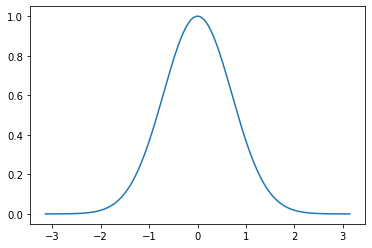

In [5]:
y_fft = ifft(z_fft)
plt.plot(x, y_fft.real)
error(y_fft, y)

# Circular Discrete Convolution

Les séquences sont de longueur $n$ et les indices sont vu dans $Z/nZ$.

$$ (x*y)(k) = \sum_{j=0}^{n-1}x_j y_{k-j}  $$


In [6]:
def conv(x, y):
    assert(len(x) == len(y))
    n = len(x)
    L = np.zeros_like(x)
    for k in range(n):
        for j in range(n):
            L[k] += x[j] * y[(k-j)%n]
    return L

In [7]:
def conv_fft(x, y):
    assert(len(x) == len(y))
    return ifft(fft(x) * fft(y))

Error :  1.0191348089857943e-15


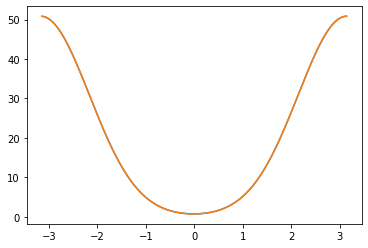

In [8]:
c = conv(y, y)
c_fft = conv_fft(y, y)
plt.plot(x, c)
plt.plot(x, c_fft.real)
error(c_fft, c)

# Fractional Fourier Transform

$$ G_k(x, \alpha)= \sum_{j=0}^{n-1}x_je^{-2i\pi jk\alpha} = e^{-i\pi k^2 \alpha} \sum_{j=0}^{n-1}y_jz_{k-j}$$

avec

$$ y_j = x_je^{-i\pi j^2 \alpha} \text{  et  } z_j = e^{i\pi j^2 \alpha} $$ 

Attention, $z_{k-j} \neq z_{n+k-j}$ : on ne peut pas utiliser directement une convolution discrète circulaire.

In [9]:
def frac_dft(X, a):
    n = len(X)
    L = np.zeros_like(X, dtype=complex)
    for k in range(n):
        for j in range(n):
            L[k] += X[j]*np.exp(-2*1j*np.pi*j*k*a)
    return L

def frac_fft(X, a):
    n = len(X)
    j = np.arange(n)
    y = X * np.exp(-1j*np.pi*j*j*a)
    z = np.exp(1j*np.pi*j*j*a)
    
    Y = np.zeros(2*n, dtype=complex)
    Z = np.zeros(2*n, dtype=complex)
    Y[:n] = y
    Z[:n] = z
    Z[n+1:] = z[:0:-1]
    return np.exp(-1j*np.pi*j*j*a) * conv_fft(Y, Z)[:n]

In [10]:
z_frac_dft = frac_dft(y, 1/len(x))
y_frac_dft = frac_dft(z_frac_dft, -1/len(x))/len(x)
error(z_frac_dft, z_dft)
error(y_frac_dft, y)
error(frac_fft(y, np.sqrt(5)), frac_dft(y, np.sqrt(5)))

Error :  0.0
Error :  6.069270725473981e-14
Error :  8.282353362166894e-12


# Continuous Fourier Transform

$f$ est nulle hors de $[-\frac{a}{2}, \frac{a}{2}]$

$$ F(x) = \int_{-\infty}^{+\infty} f(t)e^{-itx}dt = \int_{-\frac{a}{2}}^{+\frac{a}{2}} f(t)e^{-itx}dt $$

$f$ est connue en $n$ points répartis uniformément sur $[-\frac{a}{2}, \frac{a}{2}]$, i.e $t_k=-\frac{a}{2} + k \frac{a}{n}$ pour $0 \le k < n$.

On souhaite évaluer $F$ en $n$ points répartis uniformément sur $[-\frac{b}{2}, \frac{b}{2}]$, i.e $x_k=-\frac{b}{2} + k \frac{b}{n}$ pour $0 \le k < n$.

$$ F(x_k) = \int_{-\frac{a}{2}}^{+\frac{a}{2}} f(t)e^{-itx_k}dt 
          = \frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-it_jx_k}
          = \frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-i(-\frac{a}{2} + j \frac{a}{n})x_k} $$
$$        = e^{i\frac{a}{2}x_k}\frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-i j \frac{a}{n}x_k}
          = e^{i\frac{a}{2}x_k}\frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{-i j \frac{a}{n}(-\frac{b}{2} + k\frac{b}{n})}
          = e^{i\frac{a}{2}x_k}\frac{a}{n}\sum_{j=0}^{n-1}f(t_j)e^{i j \frac{a}{n}\frac{b}{2}}e^{-i j \frac{a}{n} k\frac{b}{n}}
$$ 

On reconnait une transformée fractionnaire avec $-i j \frac{a}{n} k\frac{b}{n} = -2i\pi jk\alpha$ soit 
$\frac{a}{n} \frac{b}{n} = 2\pi \alpha$ soit
$\alpha = \frac{ab}{2\pi n^2}$

$$ F(x_k) = e^{i\frac{a}{2}(-\frac{b}{2} + k \frac{b}{n})}\frac{a}{n} G_k\left(\left( f(-\frac{a}{2} + j \frac{a}{n})e^{i j \frac{ab}{2n}}\right)_{0 \le j < n}, \alpha\right) $$ 

In [11]:
def cft(f, a, b, n):
    result = np.zeros(n, dtype=complex)
    for k in range(n):
        for j in range(n):
            tj = -a/2 + j*a/n
            xk = -b/2 + k*b/n
            result[k] += a/n*f(tj)*np.exp(-1j*tj*xk)
    return result

def cfft(f, a, b, n):
    f_vect = np.vectorize(f)
    
    k = np.arange(n)
    xk = -b/2 + (b/n)*k
    tk = -a/2 + (a/n)*k
    
    prefactor = (a/n) * np.exp(1j*(a/2)*xk)
    y = f_vect(tk) * np.exp(1j*a*b/(2*n)*k)
    alpha = a*b / (2*np.pi*n*n)
    
    return prefactor * frac_fft(y, alpha)

Error :  5.751925482141584e-07
Error :  3.3444487910564823e-15


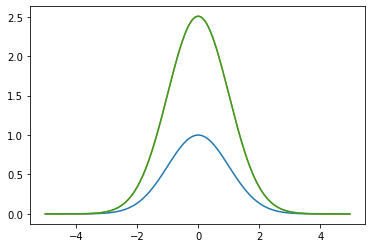

In [12]:
f = lambda x: np.exp(-x*x/2)
a = 10
b = 10
n = 256

tk = -a/2 + (a/n)*np.arange(n)
xk = -b/2 + (b/n)*np.arange(n)

error(cft(f, a, b, n), np.sqrt(2*np.pi)*f(xk)) # Simpson would be better
error(cfft(f, a, b, n), cft(f, a, b, n))

plt.plot(tk, f(tk))
plt.plot(xk, cft(f, a, b, n).real)
plt.plot(xk, cfft(f, a, b, n).real)
plt.show()